 # MLP robustness on MNIST

 In this notebook we evaluate the samples we collected over different runs on MNIST.

In [1]:
import os, sys, re
from jax import numpy as jnp
import numpy as onp
import jax
import tensorflow.compat.v2 as tf
import argparse
import time
import tqdm
from collections import OrderedDict

sys.path.append('.')

from covs.utils import data_utils
from covs.utils import models
from covs.utils import metrics
from covs.utils import losses
from covs.utils import checkpoint_utils
from covs.utils import cmd_args_utils
from covs.utils import logging_utils
from covs.utils import train_utils
from covs.utils import precision_utils

from itertools import chain

from matplotlib import pyplot as plt
import matplotlib


2021-12-14 15:53:47.079929: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
dtype = jnp.float32
train_set, test_set, task, data_info = data_utils.make_ds_pmap_fullbatch(
    "mnist", dtype)
test_labels = test_set[1]

net_apply, net_init = models.get_model("mlp_classification", data_info)
net_apply = precision_utils.rewrite_high_precision(net_apply)
(_, predict_fn, ensemble_upd_fn, _,_) = train_utils.get_task_specific_fns(task, data_info)


2021-12-14 15:53:51.378538: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-14 15:53:51.378646: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
def predict_hmc(ds, basepath):
    ckpts = sorted([p for p in os.listdir(basepath) if p.endswith('pt')], key=lambda p: int(re.search('\d+', p)[0]))
    # print(ckpts)
    ensemble_predictions = None
    num_ensembled = 0
    last_test_predictions = None

    for ckpt in tqdm.tqdm(ckpts):
        path = os.path.join(basepath, ckpt)
        try:
            checkpoint_dict = checkpoint_utils.load_checkpoint(path)
        except:
            continue
        _, params, net_state, _, _, accepted, _, _ = (
            checkpoint_utils.parse_hmc_checkpoint_dict(checkpoint_dict))
        if accepted:
            _, test_predictions = onp.asarray(
                predict_fn(net_apply, params, net_state, ds))
            ensemble_predictions = ensemble_upd_fn(
                ensemble_predictions, num_ensembled, test_predictions)
            num_ensembled += 1
            last_test_predictions = test_predictions
    print(num_ensembled)
    return ensemble_predictions, last_test_predictions
        


In [4]:
alldirs = {}
priors = [
    'Gaussian',
    'EmpCov',
    'Laplace',
    'StudentT'
]

for prior in priors:
    prefix = "runs/covshift/hmc/" + prior.lower()
    dirs = os.listdir(prefix)
    for path in dirs:
        label = f'HMC {prior} Prior'
        full_path = os.path.join(prefix, path)
        wd = float(full_path.split("_")[4])
        stepsize = float(full_path.split("_")[6])
        trajlen = float(full_path.split("_")[8])
    #     name = "Gaussian wd={} T=1".format(wd, stepsize)
        alldirs[label] = full_path

alldirs


{'HMC Gaussian Prior': 'runs/covshift/hmc/gaussian/model_mlp_classification_wd_100.0_stepsize_1e-05_trajlen_0.15_burnin_10_mh_True_temp_1.0_seed_2',
 'HMC EmpCov Prior': 'runs/covshift/hmc/empcov/model_mlp_classification_wd_100.0_stepsize_1e-05_trajlen_0.15_burnin_10_mh_True_temp_1.0_seed_0',
 'HMC Laplace Prior': 'runs/covshift/hmc/laplace/model_mlp_classification_wd_3.0_stepsize_6e-05_trajlen_0.9_burnin_10_mh_True_temp_1.0_seed_0',
 'HMC StudentT Prior': 'runs/covshift/hmc/studentt/model_mlp_classification_wd_10.0_stepsize_0.0001_trajlen_0.49_burnin_10_mh_True_temp_1.0_seed_0'}

In [5]:
sgddirs = {}
prefix = "runs/covshift/sgd/"

dirs = os.listdir(prefix)
for path in dirs:
    if path[:3] != "sgd":
        continue
    full_path = os.path.join(prefix, path, "model_step_99.pt")
    wd = float(full_path.split("_")[13])
    # name = "SGD wd= {}".format(wd)
    name = 'MAP'
    sgddirs[name] = full_path
        
sgddirs


{'MAP': 'runs/covshift/sgd/sgd_mom_0.9__lr_sch_i_1e-07___epochs_100_wd_100.0_batchsize_80_temp_1.0__seed_0/model_step_99.pt'}

 ## Gaussian Noise

In [6]:
sgd_ind_accs = {key: [] for key in sgddirs}
hmc_ind_accs = {key: [] for key in alldirs}
hmc_ens_accs = {key: [] for key in alldirs}

noise_scales = onp.linspace(0, 10., 10)
for noise_scale in noise_scales:
    noisy_test_set = test_set[0] + jax.random.normal(jax.random.PRNGKey(0), test_set[0].shape) * noise_scale, test_set[1]
    
    for key, path in chain(alldirs.items()):
        hmc_predictions, predictions = predict_hmc(noisy_test_set, path)
        if hmc_predictions is None: continue
        hmc_ens_accs[key].append(metrics.accuracy(hmc_predictions, test_labels))
        hmc_ind_accs[key].append(metrics.accuracy(predictions, test_labels))

    for key, path in sgddirs.items():
        checkpoint_dict = checkpoint_utils.load_checkpoint(path)
        _, params, net_state, _, _ = (
            checkpoint_utils.parse_sgd_checkpoint_dict(checkpoint_dict))
        predictions = onp.asarray(predict_fn(net_apply, params, net_state, noisy_test_set)[1])
        sgd_ind_accs[key].append(metrics.accuracy(predictions, test_labels))


  0%|          | 0/100 [00:00<?, ?it/s]/home/tcai/miniconda3/envs/hmc/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
100%|██████████| 100/100 [00:09<00:00, 10.51it/s]


99


  3%|▎         | 3/100 [00:00<00:04, 22.98it/s]

0


  2%|▏         | 2/100 [00:00<00:05, 18.10it/s]

94


  0%|          | 0/100 [00:00<?, ?it/s]

90


  5%|▌         | 5/100 [00:00<00:01, 49.54it/s]

99


  3%|▎         | 3/100 [00:00<00:03, 25.77it/s]

0


  3%|▎         | 3/100 [00:00<00:04, 20.71it/s]

94


  0%|          | 0/100 [00:00<?, ?it/s]

90


  6%|▌         | 6/100 [00:00<00:01, 57.95it/s]

99


  3%|▎         | 3/100 [00:00<00:03, 27.75it/s]

0


  2%|▏         | 2/100 [00:00<00:05, 19.42it/s]

94


  0%|          | 0/100 [00:00<?, ?it/s]

90


  4%|▍         | 4/100 [00:00<00:02, 35.55it/s]

99


  2%|▏         | 2/100 [00:00<00:04, 19.86it/s]

0


  0%|          | 0/100 [00:00<?, ?it/s]

94


  0%|          | 0/100 [00:00<?, ?it/s]

90


  6%|▌         | 6/100 [00:00<00:01, 53.30it/s]

99


  3%|▎         | 3/100 [00:00<00:03, 27.17it/s]

0


  2%|▏         | 2/100 [00:00<00:05, 18.80it/s]

94


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


90


  4%|▍         | 4/100 [00:00<00:02, 32.38it/s]

99


  3%|▎         | 3/100 [00:00<00:04, 22.67it/s]

0


  3%|▎         | 3/100 [00:00<00:05, 18.61it/s]

94


  0%|          | 0/100 [00:00<?, ?it/s]

90


  3%|▎         | 3/100 [00:00<00:04, 23.69it/s]

99


  2%|▏         | 2/100 [00:00<00:05, 19.35it/s]

0


  1%|          | 1/100 [00:00<00:11,  8.73it/s]

94


  0%|          | 0/100 [00:00<?, ?it/s]

90


  5%|▌         | 5/100 [00:00<00:01, 47.65it/s]

99


  2%|▏         | 2/100 [00:00<00:08, 11.86it/s]

0


  0%|          | 0/100 [00:00<?, ?it/s]

94


  0%|          | 0/100 [00:00<?, ?it/s]

90


  4%|▍         | 4/100 [00:00<00:02, 35.83it/s]

99


  3%|▎         | 3/100 [00:00<00:04, 20.69it/s]

0


  1%|          | 1/100 [00:00<00:12,  8.24it/s]

94


  0%|          | 0/100 [00:00<?, ?it/s]

90


  5%|▌         | 5/100 [00:00<00:02, 44.35it/s]

99


  3%|▎         | 3/100 [00:00<00:05, 16.38it/s]

0


  0%|          | 0/100 [00:00<?, ?it/s]

94


100%|██████████| 100/100 [00:10<00:00,  9.90it/s]


90


In [20]:
alldirs

{'HMC Gaussian Prior': 'runs/covshift/hmc/gaussian/model_mlp_classification_wd_100.0_stepsize_1e-05_trajlen_0.15_burnin_10_mh_True_temp_1.0_seed_2',
 'HMC EmpCov Prior': 'runs/covshift/hmc/empcov/model_mlp_classification_wd_100.0_stepsize_1e-05_trajlen_0.15_burnin_10_mh_True_temp_1.0_seed_0',
 'HMC Laplace Prior': 'runs/covshift/hmc/laplace/model_mlp_classification_wd_3.0_stepsize_6e-05_trajlen_0.9_burnin_10_mh_True_temp_1.0_seed_0',
 'HMC StudentT Prior': 'runs/covshift/hmc/studentt/model_mlp_classification_wd_10.0_stepsize_0.0001_trajlen_0.49_burnin_10_mh_True_temp_1.0_seed_0'}

In [7]:
path = alldirs['HMC EmpCov Prior']
# predict_hmc(noisy_test_set, path)
ckpts = sorted([p for p in os.listdir(path) if p.endswith(
    'pt')], key=lambda p: int(re.search('\d+', p)[0]))
ckpt_path = os.path.join(path, ckpts[-2])
checkpoint_utils.load_checkpoint(ckpt_path)


{'iteration': 98,
 'params': FlatMapping({
   'linear': FlatMapping({
               'b': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          

Text(0.5, 1.0, 'Robustness to Gaussian Noise')

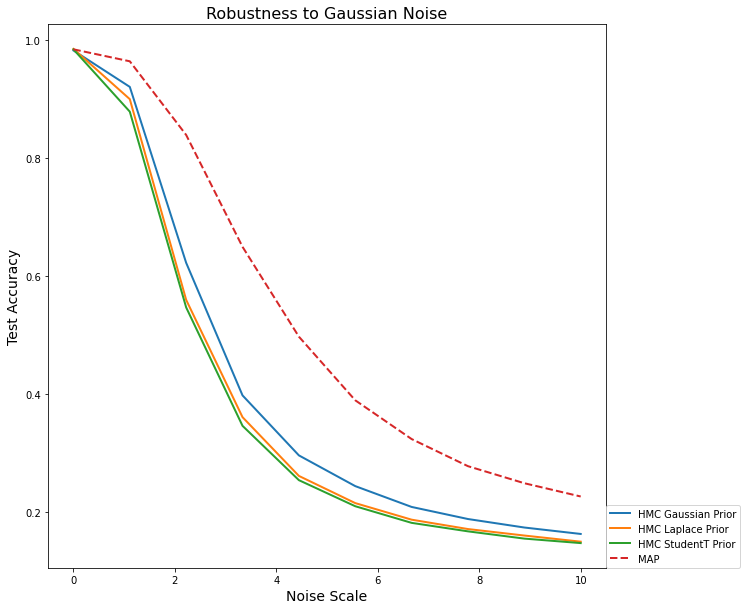

In [8]:
plt.figure(figsize=(10, 10))
for key, _ in alldirs.items():
    if hmc_ens_accs[key] == []:
        continue
    style = "-"
    plt.plot(noise_scales, hmc_ens_accs[key], style, lw=2, label=key, ms=10)
for key, _ in sgddirs.items():
    plt.plot(noise_scales, sgd_ind_accs[key], "--", lw=2, label=key, ms=10)
plt.legend(loc=(1., 0.))
plt.ylabel("Test Accuracy", fontsize=14)
plt.xlabel("Noise Scale", fontsize=14)
plt.title("Robustness to Gaussian Noise", fontsize=16)


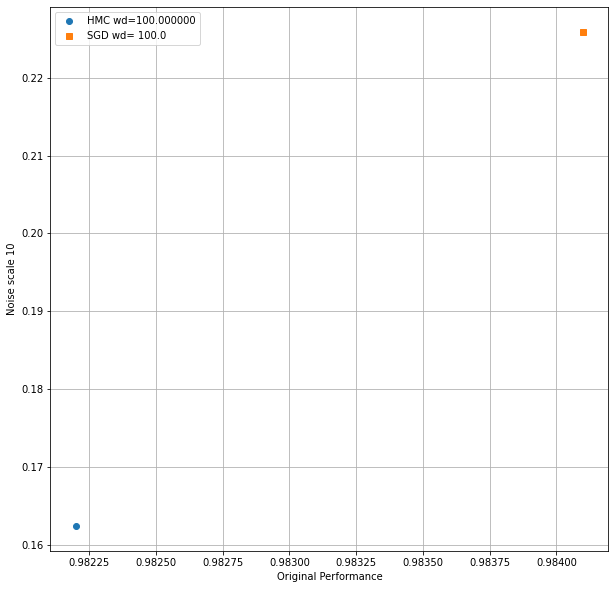

In [8]:

plt.figure(figsize=(10, 10))

# vals = onp.stack([onp.asarray(v) for _, v in hmc_ens_accs.items() if v != []])
# plt.plot(vals[:, 0], vals[:, -1], "bo")

for key, _ in alldirs.items():
    marker="o"
    if hmc_ens_accs[key] == []:
        continue
    plt.plot(hmc_ens_accs[key][0], hmc_ens_accs[key][-1], marker, label=key)
for key, _ in sgddirs.items():
    plt.plot(sgd_ind_accs[key][0], sgd_ind_accs[key][-1], "s", label=key)
    
plt.xlabel("Original Performance")
plt.ylabel("Noise scale 10")
plt.grid()
plt.legend()


In [9]:
cmap = matplotlib.cm.get_cmap("tab20")


In [26]:
wds = sorted(alldirs)
wds = [wd for wd in wds if hmc_ens_accs[wd] != []]
alphas = onp.linspace(0.3, 1., len(wds))[::-1]

plt.figure(figsize=(3, 3))
for i, wd in enumerate(wds):
    print(i)
    std = onp.sqrt(1 / wd)
    if hmc_ens_accs[wd] == []:
        continue
    plt.plot(noise_scales, hmc_ens_accs[wd], "-", lw=2, 
             label="std {:.2f}".format(std), color=cmap(i))#, alpha=alphas[i], color="g")

plt.plot(noise_scales, sgd_ind_accs["SGD wd= 100.0"], "--k", lw=2, label="SGD", ms=10)

plt.legend()
plt.grid()
plt.ylabel("Test Accuracy", fontsize=14)
plt.xlabel("Noise Scale", fontsize=14)
plt.savefig("gaussian_priors_gaussian_noise.pdf", bbox_inches="tight")


0


TypeError: unsupported operand type(s) for /: 'int' and 'str'

<Figure size 216x216 with 0 Axes>

 ## MNIST-C

In [9]:
from covs.utils import data_utils
import tensorflow_datasets as tfds

all_corruptions = tfds.image_classification.mnist_corrupted._CORRUPTIONS


In [10]:
def load_image_dataset(
    split, batch_size, name, repeat=False, shuffle=False,
    shuffle_seed=None
):
    ds, dataset_info = tfds.load(name, split=split, as_supervised=True,
                               with_info=True)
    num_classes = dataset_info.features["label"].num_classes
    num_examples = dataset_info.splits[split].num_examples
    num_channels = dataset_info.features['image'].shape[-1]
    
    def img_to_float32(image, label):
        return tf.image.convert_image_dtype(image, tf.float32), label

    ds = ds.map(img_to_float32).cache()
    ds_stats = data_utils._ALL_IMG_DS_STATS[data_utils.ImgDatasets("mnist")]
    def img_normalize(image, label):
        """Normalize the image to zero mean and unit variance."""
        mean, std = ds_stats
        image -= tf.constant(mean, shape=[1, 1, num_channels], dtype=image.dtype)
        image /= tf.constant(std, shape=[1, 1, num_channels], dtype=image.dtype)
        return image, label

    ds = ds.map(img_normalize)
    if batch_size == -1:
        batch_size = num_examples
    if repeat:
        ds = ds.repeat()
    if shuffle:
        ds = ds.shuffle(buffer_size=10 * batch_size, seed=shuffle_seed)
    ds = ds.batch(batch_size)
    return tfds.as_numpy(ds), num_classes, num_examples


def get_image_dataset(name):

    test_set, n_classes, _ = load_image_dataset("test", -1, name)
    test_set = next(iter(test_set))
    
    data_info = {
        "num_classes": n_classes
    }

    return test_set, data_info


def pmap_dataset(ds, n_devices):
    return jax.pmap(lambda x: x)(data_utils.batch_split_axis(ds, n_devices))


def make_mnistc_pmap_fullbatch(corruption, dtype, n_devices=None, truncate_to=None):
    """Make train and test sets sharded over batch dim."""
    name = get_ds_name(corruption).lower()
    n_devices = n_devices or len(jax.local_devices())
    test_set, data_info = get_image_dataset(name)
    loaded = True
    test_set = pmap_dataset(test_set, n_devices)

    test_set = test_set[0].astype(dtype), test_set[1]

    return test_set, task, data_info


def get_ds_name(corruption):
    return "mnist_corrupted/{}".format(corruption)
    

dtype = jnp.float32
test_set, task, data_info = make_mnistc_pmap_fullbatch(all_corruptions[0], dtype)
test_labels = test_set[1]

net_apply, net_init = models.get_model("mlp_classification", data_info)
net_apply = precision_utils.rewrite_high_precision(net_apply)
(_, predict_fn, ensemble_upd_fn, _,_) = train_utils.get_task_specific_fns(task, data_info)


In [11]:
sgd_ind_accs = {key: {} for key in sgddirs}
hmc_ind_accs = {key: {} for key in alldirs}
hmc_ens_accs = {key: {} for key in alldirs}

for corruption in all_corruptions:
    noisy_test_set, _, _ = make_mnistc_pmap_fullbatch(corruption, dtype)
    
    for key, path in alldirs.items():
        hmc_predictions, predictions = predict_hmc(noisy_test_set, path)
        if hmc_predictions is None:
            continue
        hmc_ens_accs[key][corruption] = metrics.accuracy(hmc_predictions, test_labels)
        hmc_ind_accs[key][corruption] = metrics.accuracy(predictions, test_labels)

    for key, path in sgddirs.items():
        checkpoint_dict = checkpoint_utils.load_checkpoint(path)
        _, params, net_state, _, _ = (
            checkpoint_utils.parse_sgd_checkpoint_dict(checkpoint_dict))
        predictions = onp.asarray(predict_fn(net_apply, params, net_state, noisy_test_set)[1])
        sgd_ind_accs[key][corruption] = metrics.accuracy(predictions, test_labels)


  0%|          | 0/100 [00:00<?, ?it/s]/home/tcai/miniconda3/envs/hmc/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
  3%|▎         | 3/100 [00:00<00:04, 23.47it/s]

99


  3%|▎         | 3/100 [00:00<00:03, 28.04it/s]

0


  3%|▎         | 3/100 [00:00<00:04, 20.68it/s]

94


100%|██████████| 100/100 [00:09<00:00, 10.14it/s]


90


  4%|▍         | 4/100 [00:00<00:02, 39.21it/s]

99


  3%|▎         | 3/100 [00:00<00:03, 24.79it/s]

0


  0%|          | 0/100 [00:00<?, ?it/s]

94


100%|██████████| 100/100 [00:09<00:00, 10.41it/s]


90


  3%|▎         | 3/100 [00:00<00:03, 26.88it/s]

99


  2%|▏         | 2/100 [00:00<00:07, 13.12it/s]

0


  2%|▏         | 2/100 [00:00<00:05, 19.35it/s]

94


100%|██████████| 100/100 [00:07<00:00, 13.61it/s]


90


  5%|▌         | 5/100 [00:00<00:02, 45.82it/s]

99


  3%|▎         | 3/100 [00:00<00:04, 19.55it/s]

0


  2%|▏         | 2/100 [00:00<00:05, 17.67it/s]

94


100%|██████████| 100/100 [00:10<00:00,  9.47it/s]


90


  4%|▍         | 4/100 [00:00<00:02, 32.00it/s]

99


  3%|▎         | 3/100 [00:00<00:03, 26.21it/s]

0


  2%|▏         | 2/100 [00:00<00:06, 15.43it/s]

94


100%|██████████| 100/100 [00:08<00:00, 11.20it/s]


90


  5%|▌         | 5/100 [00:00<00:02, 41.69it/s]

99


  3%|▎         | 3/100 [00:00<00:03, 29.33it/s]

0


  3%|▎         | 3/100 [00:00<00:05, 17.49it/s]

94


100%|██████████| 100/100 [00:08<00:00, 12.07it/s]


90


  4%|▍         | 4/100 [00:00<00:02, 35.56it/s]

99


  3%|▎         | 3/100 [00:00<00:04, 20.33it/s]

0


  1%|          | 1/100 [00:00<00:10,  9.75it/s]

94


100%|██████████| 100/100 [00:11<00:00,  8.96it/s]


90


  4%|▍         | 4/100 [00:00<00:02, 34.55it/s]

99


  3%|▎         | 3/100 [00:00<00:04, 23.02it/s]

0


  3%|▎         | 3/100 [00:00<00:04, 20.61it/s]

94


100%|██████████| 100/100 [00:07<00:00, 12.95it/s]


90


  5%|▌         | 5/100 [00:00<00:02, 42.58it/s]

99


  3%|▎         | 3/100 [00:00<00:03, 25.97it/s]

0


  0%|          | 0/100 [00:00<?, ?it/s]

94


100%|██████████| 100/100 [00:13<00:00,  7.41it/s]


90


  5%|▌         | 5/100 [00:00<00:02, 42.03it/s]

99


  3%|▎         | 3/100 [00:00<00:05, 18.74it/s]

0


  1%|          | 1/100 [00:00<00:10,  9.67it/s]

94


100%|██████████| 100/100 [00:08<00:00, 11.19it/s]


90


  4%|▍         | 4/100 [00:00<00:02, 38.21it/s]

99


  3%|▎         | 3/100 [00:00<00:04, 22.72it/s]

0


  2%|▏         | 2/100 [00:00<00:05, 17.92it/s]

94


100%|██████████| 100/100 [00:08<00:00, 11.24it/s]


90


  5%|▌         | 5/100 [00:00<00:02, 44.44it/s]

99


  3%|▎         | 3/100 [00:00<00:04, 22.79it/s]

0


  2%|▏         | 2/100 [00:00<00:04, 19.82it/s]

94


100%|██████████| 100/100 [00:08<00:00, 11.67it/s]


90


  5%|▌         | 5/100 [00:00<00:02, 40.53it/s]

99


  3%|▎         | 3/100 [00:00<00:05, 17.84it/s]

0


  2%|▏         | 2/100 [00:00<00:04, 19.83it/s]

94


100%|██████████| 100/100 [00:07<00:00, 13.28it/s]


90


  5%|▌         | 5/100 [00:00<00:02, 40.64it/s]

99


  3%|▎         | 3/100 [00:00<00:04, 19.73it/s]

0


  0%|          | 0/100 [00:00<?, ?it/s]

94


100%|██████████| 100/100 [00:08<00:00, 12.11it/s]


90


  4%|▍         | 4/100 [00:00<00:02, 32.73it/s]

99


  3%|▎         | 3/100 [00:00<00:04, 22.61it/s]

0


  2%|▏         | 2/100 [00:00<00:05, 19.10it/s]

94


100%|██████████| 100/100 [00:13<00:00,  7.51it/s]


90


  4%|▍         | 4/100 [00:00<00:02, 33.36it/s]

99


  3%|▎         | 3/100 [00:00<00:03, 29.45it/s]

0


  3%|▎         | 3/100 [00:00<00:04, 20.68it/s]

94


100%|██████████| 100/100 [00:06<00:00, 14.76it/s]

90


Text(0.5, 1.0, 'MNIST Robustness')

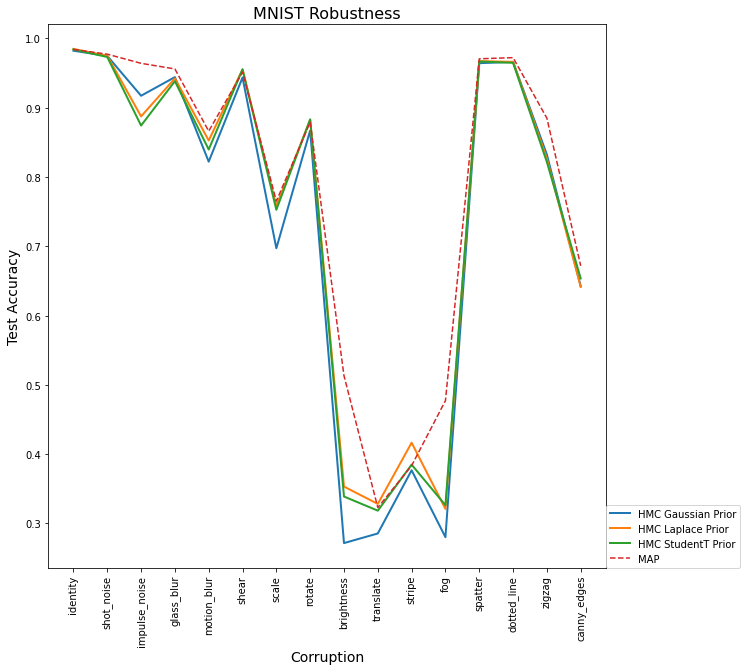

In [13]:
plt.figure(figsize=(10, 10))
xs = onp.arange(len(all_corruptions))
for key, _ in alldirs.items():
    if hmc_ens_accs[key] == {}:
        continue
    style = "-"
    if hmc_ens_accs[key]["identity"] > 0.95:
        plt.plot(xs, [hmc_ens_accs[key][c] for c in all_corruptions], style, lw=2, label=key, ms=10)

for key, _ in sgddirs.items():
    plt.plot(xs, [sgd_ind_accs[key][c] for c in all_corruptions], "--", label=key)
plt.xticks(xs, all_corruptions, rotation=90)

plt.legend(loc=(1., 0.))
plt.ylabel("Test Accuracy", fontsize=14)
plt.xlabel("Corruption", fontsize=14)
plt.title("MNIST Robustness", fontsize=16)


In [12]:
xs = onp.arange(len(all_corruptions))
plt.bar(xs, [hmc_ens_accs["Gaussian wd=100.0 T=0.0003"][c] for c in all_corruptions],
        width=0.2, label="HMC, T=3e-4"
       )
plt.bar(xs+0.2, [hmc_ens_accs["Gaussian wd=100.0 T=0.0003"][c] for c in all_corruptions],
        width=0.2, label="HMC, T=3e-4, Ind"
       )
plt.bar(xs+0.4, [sgd_ind_accs["SGD wd= 100.0"][c] for c in all_corruptions],
        width=0.2, label="SGD"
       )

plt.xticks(xs, all_corruptions, rotation=90)
plt.legend()


KeyError: 'Gaussian wd=100.0 T=0.0003'

In [19]:
cmap = matplotlib.cm.get_cmap("tab20")


In [16]:
alldirs
del alldirs['HMC EmpCov Prior']

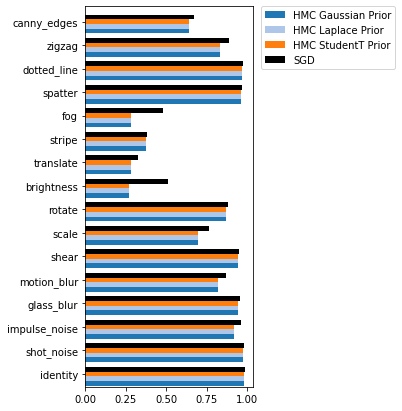

In [23]:
# wds = sorted(alldirs)
# wds = [wd for wd in wds if hmc_ens_accs[wd] != {}]

num_bars = len(alldirs) + 1
width = 0.8 / num_bars

plt.figure(figsize=(3, 7))

ys = onp.arange(len(all_corruptions))
for i, (label, _) in enumerate(alldirs.items()):
    # print(i)
    # std = onp.sqrt(1 / wd)
    plt.barh(ys + i * width, [hmc_ens_accs[wd][c] for c in all_corruptions],
        height=width, label=label, color=cmap(i)
    )
    
plt.barh(ys + (num_bars-1) * width, [sgd_ind_accs["MAP"][c] for c in all_corruptions],
        height=width, label="SGD", color="k" #cmap(len(wds)+1)
    )

plt.ylim(-0.15, 16.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.yticks(ys+0.4, all_corruptions, rotation=0);
plt.savefig("gaussian_priors_mnistc.png", bbox_inches="tight")


In [16]:
all_corruptions


['identity',
 'shot_noise',
 'impulse_noise',
 'glass_blur',
 'motion_blur',
 'shear',
 'scale',
 'rotate',
 'brightness',
 'translate',
 'stripe',
 'fog',
 'spatter',
 'dotted_line',
 'zigzag',
 'canny_edges']

In [17]:
wds = sorted(alldirs)
alphas = onp.linspace(0.3, 1., len(wds))[::-1]

plt.figure(figsize=(3, 3))
for i, wd in enumerate(wds):
    std = onp.sqrt(1 / wd)
    if hmc_ens_accs[wd] == []:
        continue
    plt.plot(noise_scales, hmc_ens_accs[wd], "-", lw=2, 
             label="std {:.2f}".format(std), color=cmap(i))#, alpha=alphas[i], color="g")

plt.plot(noise_scales, sgd_ind_accs["SGD wd= 100.0"], "--b", lw=2, label="SGD", ms=10, color=cmap(len(wds)+1))

plt.legend()
plt.grid()
plt.ylabel("Test Accuracy", fontsize=14)
plt.xlabel("Noise Scale", fontsize=14)
plt.savefig("gaussian_priors_gaussian_noise.pdf", bbox_inches="tight")


NameError: name 'noise_scales' is not defined

<Figure size 216x216 with 0 Axes>

In [18]:
hmc_ens_accs["Gaussian wd=100.0 T=0.0003"]


KeyError: 'Gaussian wd=100.0 T=0.0003'

In [ ]:
hmc_ind_accs["Gaussian wd=100.0 T=0.0003"]


 ## Noise along PCA directions

In [ ]:
from sklearn.decomposition import PCA

mnist_tr_np = onp.asarray(train_set[0]).reshape(-1, 784)
mnist_te_np = onp.asarray(test_set[0]).reshape(-1, 784)


In [ ]:
pca = PCA(n_components=50)
pca.fit(mnist_tr_np)


In [ ]:
basis = (pca.components_)


In [ ]:
plt.imshow((mnist_tr_np[0] + 2 * onp.random.randn(50) @ basis).reshape(28, 28))


In [ ]:
test_set[0].shape


In [ ]:
sgd_ind_accs = {key: [] for key in sgddirs}
hmc_ind_accs = {key: [] for key in alldirs}
hmc_ens_accs = {key: [] for key in alldirs}
n_test = 10000

noise_scales = onp.linspace(0, 10., 20)
for noise_scale in noise_scales:
    noise = (onp.random.randn(n_test, 50) @ basis).reshape(test_set[0].shape)
    noisy_test_set = test_set[0] + jnp.array(noise) * noise_scale, test_set[1]
    
    for key, path in alldirs.items():
        hmc_predictions, predictions = predict_hmc(noisy_test_set, path)
        if hmc_predictions is None:
            continue
        hmc_ens_accs[key].append(metrics.accuracy(hmc_predictions, test_labels))
        hmc_ind_accs[key].append(metrics.accuracy(predictions, test_labels))

    
    for key, path in sgddirs.items():
        checkpoint_dict = checkpoint_utils.load_checkpoint(path)
        _, params, net_state, _, _ = (
            checkpoint_utils.parse_sgd_checkpoint_dict(checkpoint_dict))
        predictions = onp.asarray(predict_fn(net_apply, params, net_state, noisy_test_set)[1])
        sgd_ind_accs[key].append(metrics.accuracy(predictions, test_labels))


In [ ]:
wds = sorted(alldirs)
wds = [wd for wd in wds if hmc_ens_accs[wd] != []]
alphas = onp.linspace(0.3, 1., len(wds))[::-1]

plt.figure(figsize=(3, 3))

wd = 10.
std = onp.sqrt(1 / wd)
plt.plot(noise_scales, hmc_ens_accs[wd], "-", lw=2, 
         label="HMC".format(std), color="g")#, alpha=alphas[i], color="g")

plt.plot(noise_scales, sgd_ind_accs["SGD wd= 100.0"], "--k", lw=2, label="SGD", ms=10)

plt.legend()
plt.grid()
plt.ylabel("Test Accuracy", fontsize=14)
plt.xlabel("Noise Scale", fontsize=14)
plt.savefig("gaussian_prior_pca_gaussian_noise.pdf", bbox_inches="tight")


In [ ]:
plt.figure(figsize=(10, 10))

# vals = onp.stack([onp.asarray(v) for _, v in hmc_ens_accs.items() if v != []])
# plt.plot(vals[:, 0], vals[:, -1], "bo")

for key, _ in alldirs.items():
    if hmc_ens_accs[key] == []:
        continue
    if key == "Gaussian wd=10":
        marker = "*"
    else:
        marker="o"
    plt.plot(hmc_ens_accs[key][0], hmc_ens_accs[key][-1], marker, label=key)
for key, _ in sgddirs.items():
    plt.plot(sgd_ind_accs[key][0], sgd_ind_accs[key][-1], "s", label=key)
    
plt.xlabel("Original Performance")
plt.ylabel("Noise scale 10")
plt.grid()
plt.legend()